# CMASS demonstration

A fresh example of CMASS (Compressive MultiAgent System Sensing) algorithm in operation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cmass.agent import *
from cmass.controller import *
from cmass.massimulator import * 
from cmass.adj_mat_gen import *
from cmass.sensor import *
from cmass.datacenter import *

In [2]:
# Set simulation parameters
t1 = 60. # total simulation time (in seconds)
tc = 0. # time at which cluster control starts
dt = 0.01 # simulation time step
i1 = int(t1 // dt) # total number of iterations
np.random.seed(2) # set constant seed for ease of monitoring

In [3]:
# Set the number of agents and true number of clusters
n_agents = 16
n_clusters = 4

In [4]:
# Generate adjacency matrix
adj_mat = example_squares_16()

In [5]:
# Generate a map {agent : cluster}
cluster_map = {}
for i in range(n_agents):
    cluster_map[i] = i // (n_agents // n_clusters)

In [6]:
# Set local control strength
rho = 0.5

# w_i = 4.1, 4.2, 4.3, 4.4, 8.1, 8.2, 8.3, 8.4, 12.1, 12.2, 12.3, 12.4, 16.1, 16.2, 16.3, 16.4
w_disp = 4.
w_per_cluster = np.arange(1, 5) * 0.1
w_nat_matrix = np.array([(i+1) * w_disp + w_per_cluster for i in range(n_clusters)])
nat_freqs = w_nat_matrix.flatten() / rho

# mu_1 = mu_5 = mu_9 = mu_13 = 0.375, 
# mu_2 = mu_6 = mu_10 = mu_14 = 0.75,
# mu_3 = mu_7 = mu_11 = mu_15 = 1.125,
# mu_4 = mu_5 = mu_12 = mu_16 = 1.5
mus = np.tile(np.arange(1, n_clusters+1) / n_clusters, n_clusters) * 1.5 

# Generate randomized frequencies for sinusoidal cluster control
f0s = 0.5 * np.sqrt(np.random.rand(n_clusters))

In [7]:
# Sensor parameters
n_pixels = 200
exposure_time = .1
fov_top = 20
fov_bot = 0
sensor_resolution = (fov_top - fov_bot) / n_pixels

cs_m = int(1/2.5 * n_pixels) # 2.5x compression
meas_mat = np.random.randn(cs_m, n_pixels) * 1/cs_m

In [8]:
# Initialize the simulator
sim = KuramotoSimulator(n_agents, dt, adj_mat, cluster_map, tc, rho, mus, f0s, nat_freqs)

In [9]:
# Initialize the sensor
sensor = Sensor(n_pixels, exposure_time, fov_top, fov_bot, dt, meas_mat, cs_m)

In [10]:
# Full progress recording at each iteration
thetas = np.zeros((n_agents, i1))
thetas_dot = np.zeros_like(thetas)

In [11]:
# Simulation iterations with recording
current_states = np.asarray(sim.get_all_outputs())
for iter in range(i1):
    thetas[:, iter] = current_states
    sim.update_all_states()
    new_states = np.asarray(sim.get_all_outputs())
    theta_dot = np.divide(new_states - current_states, dt)
    thetas_dot[:, iter] = theta_dot
    sensor.accept_sample(theta_dot)
    current_states = new_states

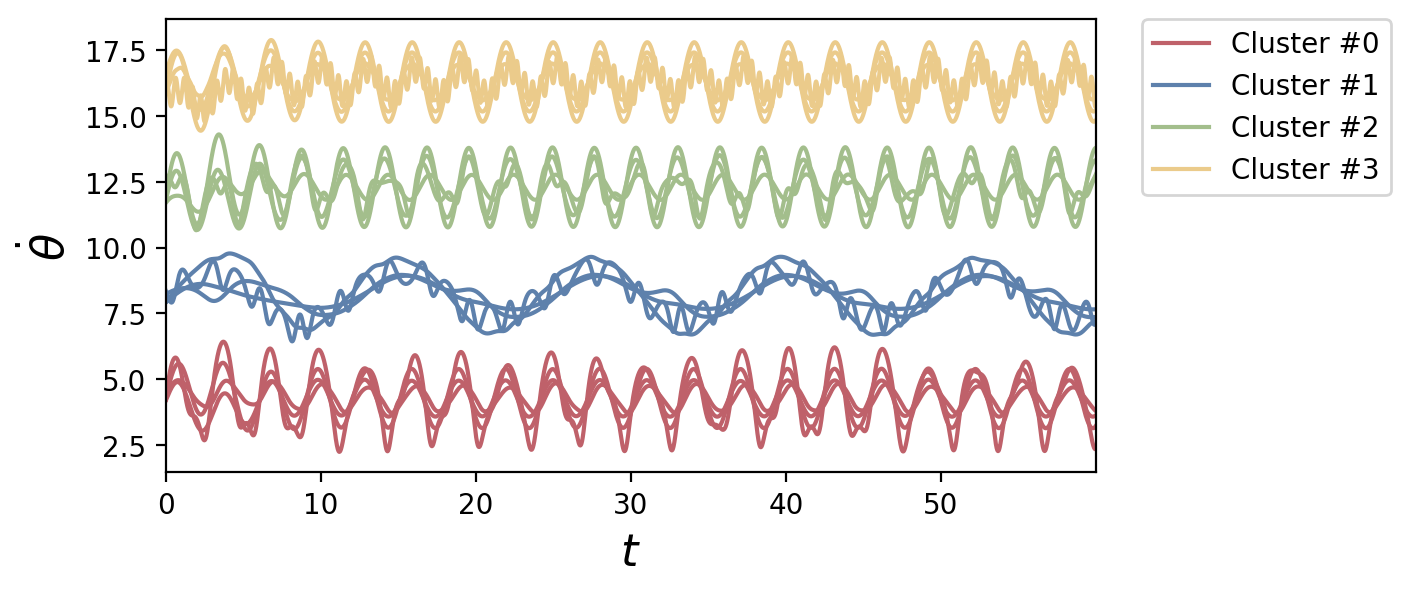

In [12]:
# Visualize
figure_figsize = (6, 3) 
figure_dpi = 200 
plt.figure(figsize=figure_figsize, dpi=figure_dpi)
colors = ['#BF616A', '#5E81AC' , '#A3BE8C', '#EBCB8B']
for i in range(n_agents):
    color = colors[int(i/n_clusters)]
    label = f"Cluster #{int(i/n_clusters)}" if i % n_clusters == 0 else ""
    plt.plot(np.linspace(0., t1, i1), thetas_dot[i], '-', color=color, label=label)
plt.xlabel(r'$t$', fontsize=16)
plt.ylabel(r'$\dot{\theta}$', fontsize=16)
plt.xlim(0, i1 * dt)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

In [13]:
# Get recorded data
cs_rec, full_rec = sensor.get_recording()

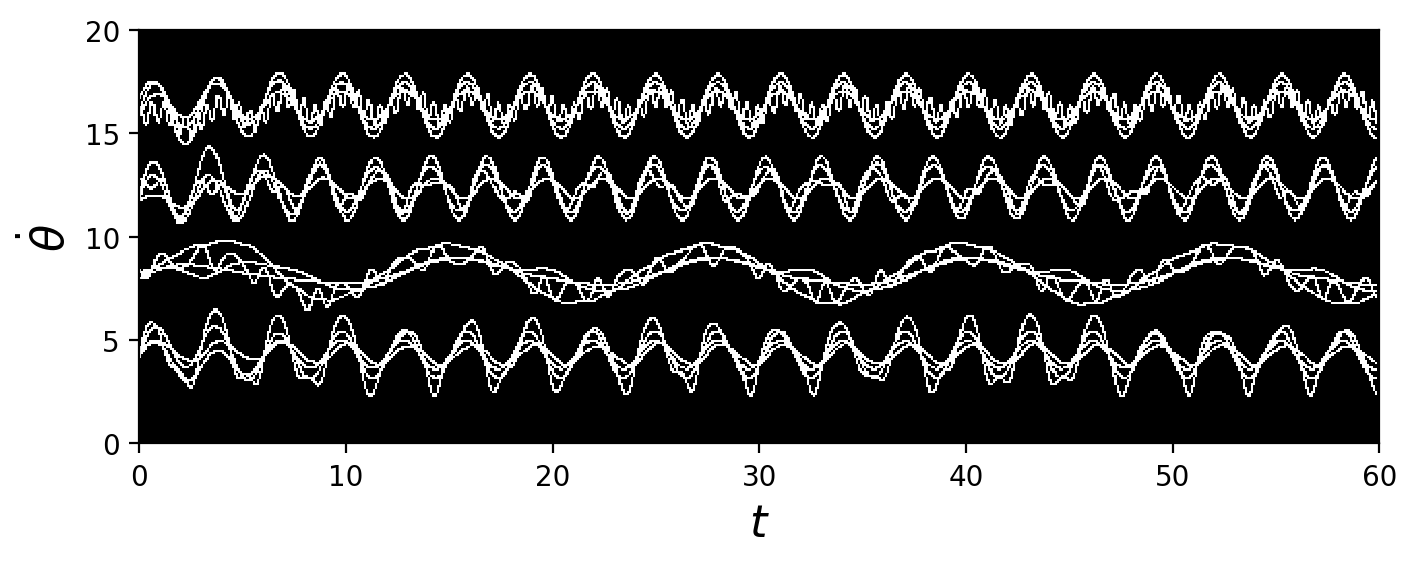

In [14]:
# Visualize full recorded data
figure_figsize = (8, 4) 
figure_dpi = 200
plt.figure(figsize=figure_figsize, dpi=figure_dpi)
plt.imshow(full_rec, origin='lower', cmap='gray', extent=[0, t1, fov_bot, fov_top])
plt.xlabel(r'$t$', fontsize=16)
plt.ylabel(r'$\dot{\theta}$', fontsize=16)
plt.show()

In [15]:
# Reconstruct each frame
reconst_rec = np.zeros_like(full_rec)
n_frames = full_rec.shape[1]
for i in range(n_frames):
    reconst_rec[:, i] = get_reconst_recording(cs_rec[:, i], meas_mat, n_pixels)

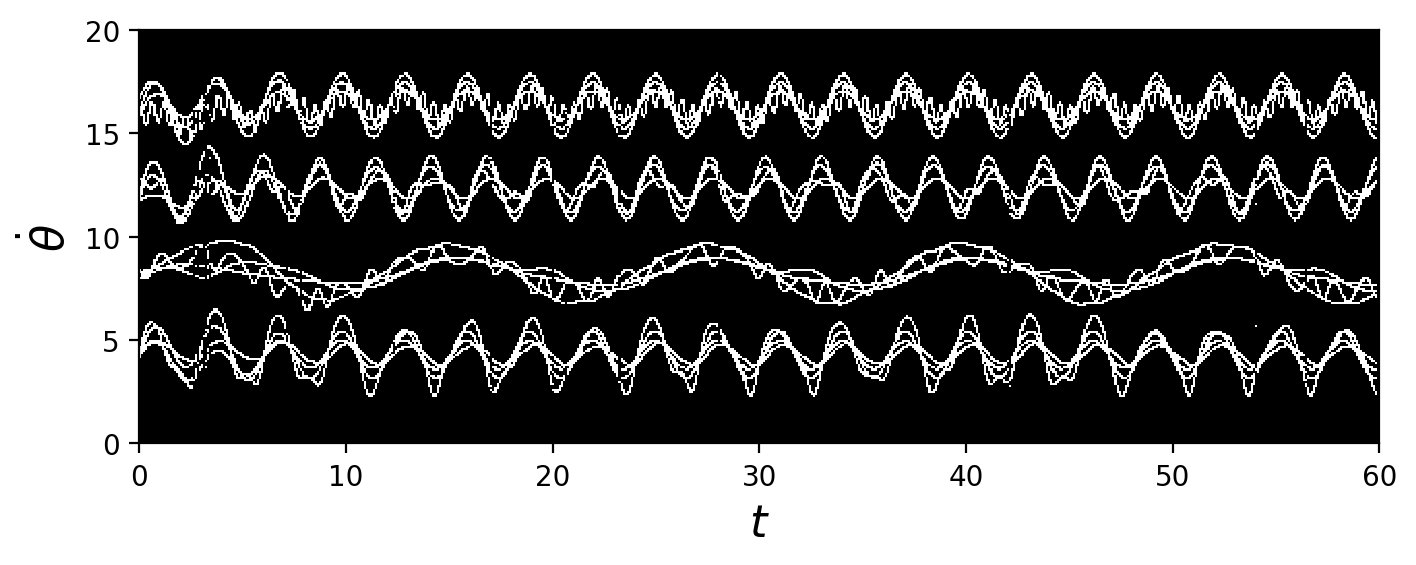

In [16]:
# Visualize reconstructed recorded data
figure_figsize = (8, 4) 
figure_dpi = 200
plt.figure(figsize=figure_figsize, dpi=figure_dpi)
plt.imshow(reconst_rec, origin='lower', cmap='gray', extent=[0, t1, fov_bot, fov_top])
plt.xlabel(r'$t$', fontsize=16)
plt.ylabel(r'$\dot{\theta}$', fontsize=16)
plt.show()

In [17]:
# Simple cluster visualizer
def show_clusters(rec, delta, min_cluster):
    """
    Visualize cluster centroids and get metrics.

    Args:
        rec: Array of frames
        delta: Clusterization threshold
        min_clust: Min size of a cluster, anything below would be considered as an outlier

    Returns:
        accuracy: Calculated accuracy
    """
    plt.figure(figsize=figure_figsize, dpi=figure_dpi)
    plt.imshow(rec, origin='lower', cmap='gray', extent=[0, t1, fov_bot, fov_top])

    cmax = []
    frame_ticks = np.arange(0, t1, exposure_time)
    for i in range(frame_ticks.size-1):
        x = rec[:, i]
        c, l = get_cluster_data(x, delta, min_cluster) 
        if len(c) > 0:
            c = c * sensor_resolution
            cmax.append(c.size)
            t_val = np.full(c.shape, frame_ticks[i]) + exposure_time * 0.5
            plt.scatter(t_val, c, color='r', s=0.3)

    accuracy = clusterization_accuracy(cmax, n_clusters)

    plt.xlabel(r'$t$', fontsize=16)
    plt.ylabel(r'$\dot{\theta}$', fontsize=16)
    plt.xlim(0, t1)
    plt.ylim(fov_bot, fov_top)
    plt.show()

    return accuracy

In [18]:
# Set delta (hierarchical clusterization threshold) and minimum cluster (below which are outliers)
delta = 8
min_cluster = 2

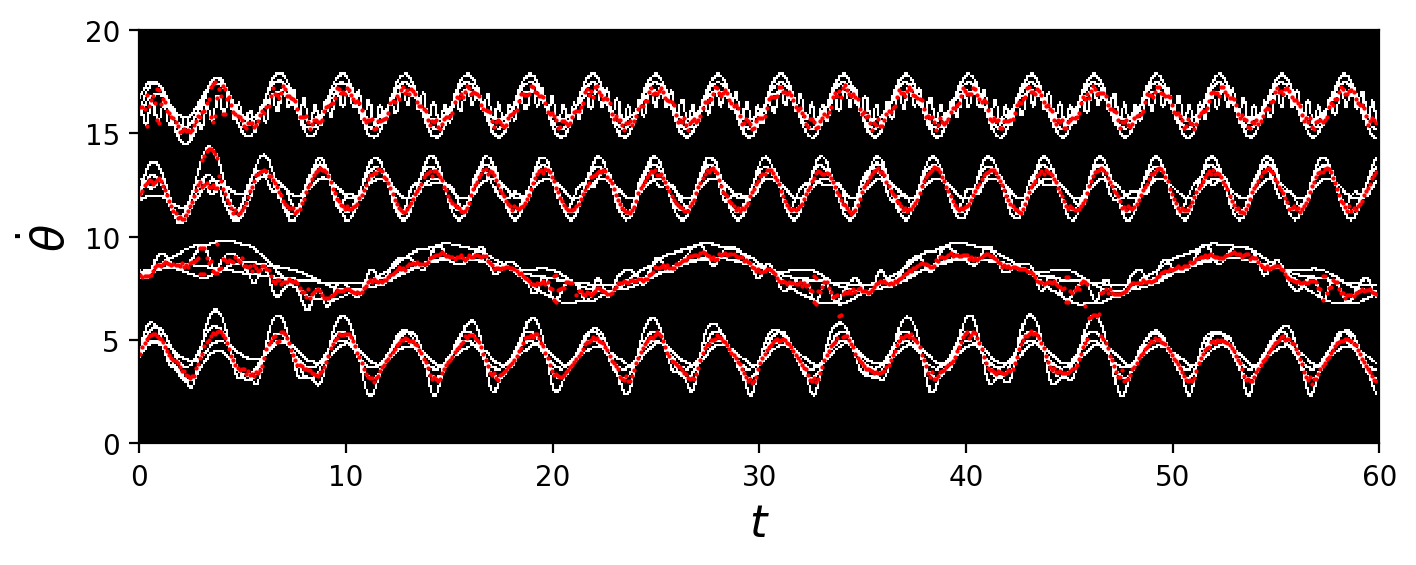

Original frames clusterization accuracy: 0.9482470784641068


In [19]:
# Evaluate full original data
original_accuracy = show_clusters(full_rec, delta, min_cluster)
print("Original frames clusterization accuracy:", original_accuracy)

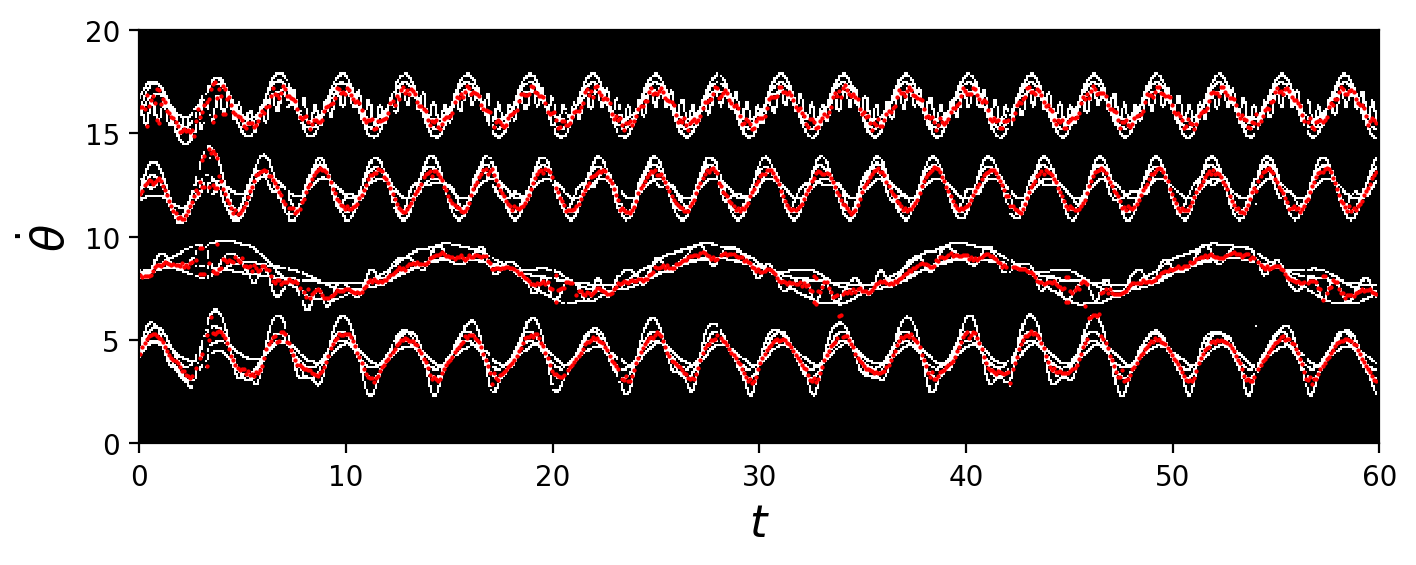

Reconstructed frames clusterization accuracy: 0.9298831385642737


In [20]:
# Evaluate reconstructed data
reconst_accuracy = show_clusters(reconst_rec, delta, min_cluster)
print("Reconstructed frames clusterization accuracy:", reconst_accuracy)